In [1]:
!pip install pytorch-model-summary
import os
from pytorch_model_summary import summary
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import cv2
import warnings
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision import models
import random
from sklearn.utils import shuffle
import numpy as np
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/besbes1/kagcof'
od.download(dataset_url)

100%|██████████| 1.44G/1.44G [01:02<00:00, 24.7MB/s]


In [5]:
def dataset_to_class_wise_csv(datafolder_path = "/content/kagcof/kagCof"):
    list_of_dir = os.listdir(datafolder_path)
    dataset = list()
    for index,class_name in enumerate(list_of_dir):
        dir_name = os.path.join(datafolder_path , class_name)
        list_of_images = os.listdir(dir_name)
        for image_name in tqdm(list_of_images):
            image_path = os.path.join(dir_name,image_name)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (256, 256))
            red , green , blue = cv2.split(img)
            try:
                pca = PCA(10)
                red_transformed = pca.fit_transform(red)
                ica = FastICA(n_components = 10,max_iter=10)
                red_transformed = ica.fit_transform(red)
                dataset.append(dict(class_name = class_name,class_id = index,image_path = image_path))
            except Exception as e:
                print(e)
    dataset = pd.DataFrame(dataset , columns = ["class_name","class_id","image_path"])
    return dataset
dataset = dataset_to_class_wise_csv()

100%|██████████| 604/604 [01:38<00:00,  6.12it/s]


In [6]:
# train val and test split in 70% , 20% , 10%
x_train,x_test,y_train,y_test = train_test_split(dataset["image_path"],dataset["class_id"],test_size = 0.1 , stratify = dataset["class_id"])
x_train,x_val , y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2 , stratify = y_train)

# Architecure 3

In [7]:
class CustomDataset(Dataset):
    def __init__(self,x,y,transforms):
        super(CustomDataset,self).__init__()
        self.x = list(x)
        self.y = list(y)
        self.transforms = transforms
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        image = Image.open(self.x[index]).convert("RGB")
        if self.transforms != None:
            image = self.transforms(image)
        return image,torch.tensor(self.y[index],dtype = torch.long)
def get_dataloader(x_train,y_train,x_test,y_test,x_val,y_val,batch_size):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Resize((256,256)),
                                  transforms.Normalize(mean = (0.485, 0.456, 0.406),std = (0.229, 0.224, 0.225))
                                   ])
    train_dataset = CustomDataset(x_train,y_train,transform)
    val_dataset = CustomDataset(x_val,y_val,transform)
    test_dataset = CustomDataset(x_test , y_test,transform)
    train_dataloader = DataLoader(dataset = train_dataset , batch_size = batch_size , shuffle = False,drop_last = True)
    test_dataloader = DataLoader(dataset = test_dataset , batch_size = batch_size , shuffle = False,drop_last = True)
    val_dataloader = DataLoader(dataset = val_dataset , batch_size = batch_size , shuffle = False,drop_last = True)
    return train_dataloader , test_dataloader , val_dataloader
batch_size = 32
train_dataloader , test_dataloader , val_dataloader = get_dataloader(x_train,y_train,x_test,y_test,x_val ,y_val,batch_size)

In [8]:
class Model1(nn.Module):
    def __init__(self,num_classes):
        super(Model1 , self).__init__()
        self.num_classes = num_classes
        self.resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.classifier = nn.Sequential(nn.Linear(in_features = 1000,out_features = 256),
                                       nn.ReLU(),
                                       nn.BatchNorm1d(256),
                                       nn.Dropout(p = 0.5),
                                       nn.Linear(in_features = 256 , out_features = self.num_classes),
                                       nn.Softmax())
    def forward(self,x):
        resnet_output = self.resnet_model(x)
        final_output = self.classifier(resnet_output)
        return final_output
class Model2(nn.Module):
    def __init__(self,num_classes):
        super(Model2 , self).__init__()
        self.num_classes = num_classes
        self.googlenet_model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        self.classifier = nn.Sequential(nn.Linear(in_features = 1000,out_features = 256),
                                       nn.ReLU(),
                                       nn.BatchNorm1d(256),
                                       nn.Dropout(p = 0.5),
                                       nn.Linear(in_features = 256 , out_features = self.num_classes),
                                       nn.Softmax())
    def forward(self,x):
        google_net_output = self.googlenet_model(x)
        final_output = self.classifier(google_net_output)
        return final_output
class Model3(nn.Module):
    def __init__(self,num_classes):
        super(Model3 , self).__init__()
        self.num_classes = num_classes
        self.inception_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        self.inception_model = nn.Sequential(*(list(self.inception_model.children())[:-1]))
        self.classifier = nn.Sequential(nn.Linear(in_features = 2048,out_features = 512),
                                       nn.ReLU(),
                                       nn.BatchNorm1d(512),
                                       nn.Dropout(p = 0.5),
                                       nn.Linear(in_features = 512 , out_features = self.num_classes),
                                       nn.Softmax())
    def forward(self,x):
        inception_output = self.inception_model[0](x)
        for layer_no in range(1,20):
            if layer_no != 15:
                inception_output = self.inception_model[layer_no](inception_output)
        inception_output = inception_output.view(inception_output.size(0),-1) #(batch_size , 2048)
        final_output = self.classifier(inception_output)
        return final_output



In [9]:
print(summary(Model1(num_classes=3), torch.zeros((1, 3, 256, 256)) ,show_input=True))
print(summary(Model2(num_classes=3), torch.zeros((1, 3, 256, 256)) ,show_input=True))
print(summary(Model3(num_classes=3), torch.zeros((1, 3, 256, 256)) ,show_input=True))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          ResNet-1     [1, 3, 256, 256]      11,689,512      11,689,512
          Linear-2            [1, 1000]         256,256         256,256
            ReLU-3             [1, 256]               0               0
     BatchNorm1d-4             [1, 256]             512             512
         Dropout-5             [1, 256]               0               0
          Linear-6             [1, 256]             771             771
         Softmax-7               [1, 3]               0               0
Total params: 11,947,051
Trainable params: 11,947,051
Non-trainable params: 0
------------------------------------------------------------------------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
       GoogLeNet-1     [1, 3, 256, 256]       6,624,904       6,624,904
          Linear-2            [1, 1000]         256,256         256,256
            ReLU-3             [1, 256]               0               0
     BatchNorm1d-4             [1, 256]             512             512
         Dropout-5             [1, 256]               0               0
          Linear-6             [1, 256]             771             771
         Softmax-7               [1, 3]               0               0
Total params: 6,882,443
Trainable params: 6,882,443
Non-trainable params: 0
------------------------------------------------------------------------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
          BasicConv2d-1      [1, 3, 256, 256]             928             928
          BasicConv2d-2     [1, 32, 127, 127]           9,280           9,280
          BasicConv2d-3     [1, 32, 125, 125]          18,560          18,560
            MaxPool2d-4     [1, 64, 125, 125]               0               0
          BasicConv2d-5       [1, 64, 62, 62]           5,280           5,280
          BasicConv2d-6       [1, 80, 62, 62]         138,624         138,624
            MaxPool2d-7      [1, 192, 60, 60]               0               0
           InceptionA-8      [1, 192, 29, 29]         255,904         255,904
           InceptionA-9      [1, 256, 29, 29]         277,472         277,472
          InceptionA-10      [1, 288, 29, 29]         285,152         285,152
          InceptionB-11      [1, 288, 29, 29]       1,153,280  

In [10]:
class Train_DL_Model(object):
    def __init__(self,train_dataloader,test_dataloader,validation_dataloader,
                 model,n_epochs,n_classes,lr = 0.00001):
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.validation_dataloader = validation_dataloader
        self.n_classes = n_classes
        self.n_epochs = n_epochs
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model(self.n_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters() , lr = self.lr)
        self.criterion = nn.CrossEntropyLoss()
        self.train_prediction = []
        self.validation_prediction = []
        self.test_prediction = []
        self.train_original = []
        self.test_original = []
        self.val_original = []
    def train_model(self):
        print("Training Start...")
        num_batch = len(self.train_dataloader)
        for epoch in range(self.n_epochs):
            print("| ********* Epoch : {} ********** |".format(epoch+1))
            for index,(image,label) in enumerate(self.train_dataloader):
                image = image.to(self.device)
                label = label.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(image)
                loss = self.criterion(output , label)
                loss.backward()
                self.optimizer.step()
                if (index) % 10 == 0:
                    print("| Batch : {0}/{1} |".format(index, num_batch))
        print("Training End .....")
    def get_test_validation_prediction(self,dataloader):
        num_batch = len(dataloader)
        with torch.no_grad():
            total_prediction = []
            total_original = []
            probability = []
            for index,(image,label) in enumerate(dataloader):
                image = image.to(self.device)
                output = self.model(image)
                prediction = torch.argmax(output , axis = 1).cpu().tolist()
                total_original.extend(label.tolist())
                total_prediction.extend(prediction)
                probability.extend(output.cpu().tolist())
                if (index) % 10 == 0:
                    print("| Batch : {0}/{1} |".format(index, num_batch))
        return total_prediction,total_original,probability
    def test_validation(self):
        print("Training Prediction Start ")
        pred , original,train_probability = self.get_test_validation_prediction(self.train_dataloader)
        self.train_prediction.extend(pred)
        self.train_original.extend(original)
        print("Training Prediction End ")
        print("Validation Prediction Start ")
        pred , original, val_probability= self.get_test_validation_prediction(self.validation_dataloader)
        self.validation_prediction.extend(pred)
        self.val_original.extend(original)
        print("Validation Prediction End ")
        print("Testing Prediction Start ")
        pred , original ,test_probability= self.get_test_validation_prediction(self.test_dataloader)
        self.test_prediction.extend(pred)
        self.test_original.extend(original)
        print("Validation Prediction End ")
        return (self.train_prediction,self.validation_prediction , self.test_prediction),(self.train_original,self.val_original,self.test_original),(train_probability,val_probability,test_probability)

In [11]:
from sklearn.metrics import accuracy_score , f1_score,recall_score,precision_score,classification_report
import pickle
def calulate_result(original_data,DL):
    accuracy = dict(train = accuracy_score(original_data[0],DL[0])*100,
                   val = accuracy_score(original_data[1],DL[1])*100,
                   test = accuracy_score(original_data[2],DL[2])*100)
    print("accuracy", accuracy)
    recall = dict(train = recall_score(original_data[0],DL[0],average = "weighted")*100,
                   val = recall_score(original_data[1],DL[1],average = "weighted")*100,
                   test = recall_score(original_data[2],DL[2],average = "weighted")*100)
    print("recall", recall)
    precision = dict(train = precision_score(original_data[0],DL[0],average = "weighted")*100,
                   val = precision_score(original_data[1],DL[1],average = "weighted")*100,
                   test = precision_score(original_data[2],DL[2],average = "weighted")*100)
    print("precision", precision)
    f1 = dict(train = f1_score(original_data[0],DL[0],average = "weighted")*100,
                   val = f1_score(original_data[1],DL[1],average = "weighted")*100,
                   test = f1_score(original_data[2],DL[2],average = "weighted")*100)
    print("f1", f1)
    report = dict(train = classification_report(original_data[0],DL[0],output_dict = True),
                   val = classification_report(original_data[1],DL[1],output_dict = True),
                   test = classification_report(original_data[2],DL[2],output_dict = True))

In [20]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
def plot_curve(original_data, DL, title):
  y_1 = pd.Series(original_data)
  new_labels = {1:1, 2:0, 0:0}
  y_1 = y_1.map(new_labels)
  y_1 = y_1.to_numpy()

  y_2 = pd.Series(original_data)
  new_labels = {1:0, 2:1, 0:0}
  y_2 = y_2.map(new_labels)
  y_2 = y_2.to_numpy()

  y_0 = pd.Series(original_data)
  new_labels = {1:0, 2:0, 0:1}
  y_0 = y_0.map(new_labels)
  y_0 = y_0.to_numpy()

  y_1_pred = pd.Series(DL)
  new_labels = {1:1, 2:0, 0:0}
  y_1_pred = y_1_pred.map(new_labels)
  y_1_pred = y_1_pred.to_numpy()

  y_2_pred = pd.Series(DL)
  new_labels = {1:0, 2:1, 0:0}
  y_2_pred = y_2_pred.map(new_labels)
  y_2_pred = y_2_pred.to_numpy()

  y_0_pred = pd.Series(DL)
  new_labels = {1:0, 2:0, 0:1}
  y_0_pred = y_0_pred.map(new_labels)
  y_0_pred = y_0_pred.to_numpy()

  precision_c0, recall_c0, _ = precision_recall_curve(y_0, y_0_pred)
  precision_c1, recall_c1, _ = precision_recall_curve(y_1, y_1_pred)
  precision_c2, recall_c2, _ = precision_recall_curve(y_2, y_2_pred)
  
  fpr0, tpr0, _ = roc_curve(y_0, y_0_pred)
  fpr1, tpr1, _ = roc_curve(y_1, y_1_pred)
  fpr2, tpr2, _ = roc_curve(y_2, y_2_pred)
  
  #plot precision-recall curve
  plt.plot(precision_c0, recall_c0)
  plt.plot(precision_c1, recall_c1)
  plt.plot(precision_c2, recall_c2)
  plt.legend(["0", "1", "2"], loc ="lower right")
  plt.title(title)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.show()
  plt.savefig("PR-AUC-merged-BiGRUx3.png", dpi = 200)

  # Plot ROC AUC
  plt.plot(fpr0, tpr0)
  plt.plot(fpr1, tpr1)
  plt.plot(fpr2, tpr2)
  plt.legend(["0", "1", "2"], loc ="lower right")
  plt.title(title)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  plt.savefig("ROC-AUC-merged-BiGRUx3.png", dpi = 200)

In [12]:
# Train Model 1
n_epochs = 1
model1 = Train_DL_Model(train_dataloader,test_dataloader,val_dataloader,Model1,n_epochs,3)
model1.train_model()
model1_pred,model1_original,pred_probability1 = model1.test_validation()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training Start...
| ********* Epoch : 1 ********** |
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
Training End .....
Training Prediction Start 
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
Training Prediction End 
Validation Prediction Start 
| Batch : 0/8 |
Validation Prediction End 
Testing Prediction Start 
| Batch : 0/4 |
Validation Prediction End 


In [21]:
calulate_result(model1_original,model1_pred)

accuracy {'train': 47.67857142857143, 'val': 41.796875, 'test': 46.875}
recall {'train': 47.67857142857143, 'val': 41.796875, 'test': 46.875}
precision {'train': 57.05520138121444, 'val': 49.20444114252346, 'test': 57.80681378242354}
f1 {'train': 50.84847059827187, 'val': 44.479002832249435, 'test': 50.22828733766234}


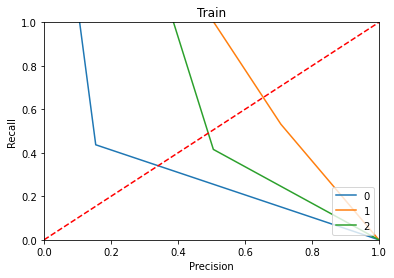

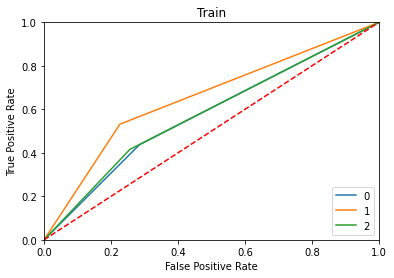

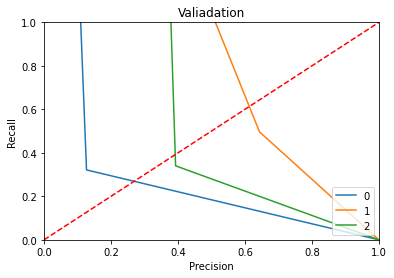

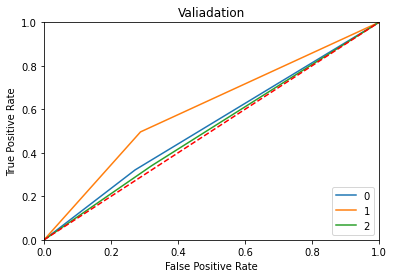

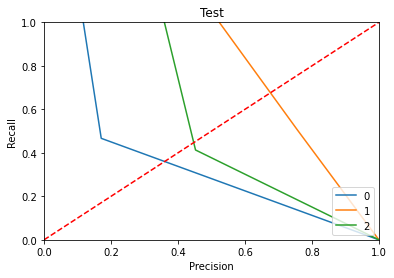

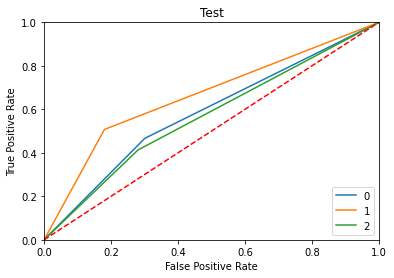

<Figure size 432x288 with 0 Axes>

In [23]:
plot_curve(model1_original[0], model1_pred[0], 'Train')
plot_curve(model1_original[1], model1_pred[1], 'Valiadation')
plot_curve(model1_original[2], model1_pred[2], 'Test')

In [17]:
# Train Model 2
n_epochs = 2
model2 = Train_DL_Model(train_dataloader,test_dataloader,val_dataloader,Model2,n_epochs,3)
model2.train_model()
model2_pred,model2_original,pred_probability2 = model2.test_validation()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training Start...
| ********* Epoch : 1 ********** |
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
| ********* Epoch : 2 ********** |
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
Training End .....
Training Prediction Start 
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
Training Prediction End 
Validation Prediction Start 
| Batch : 0/8 |
Validation Prediction End 
Testing Prediction Start 
| Batch : 0/4 |
Validation Prediction End 


In [18]:
calulate_result(model2_original,model2_pred)

accuracy {'train': 53.83928571428571, 'val': 50.390625, 'test': 46.875}
recall {'train': 53.83928571428571, 'val': 50.390625, 'test': 46.875}
precision {'train': 66.11190565095093, 'val': 64.0737951807229, 'test': 59.96738581412294}
f1 {'train': 57.11605323882104, 'val': 54.73891612268429, 'test': 51.27617853517029}


In [ ]:
plot_curve(model2_original[0], model2_pred[0], 'Train')
plot_curve(model2_original[1], model2_pred[1], 'Valiadation')
plot_curve(model2_original[2], model2_pred[2], 'Test')

In [19]:
# Train Model 3
n_epochs = 2
model3 = Train_DL_Model(train_dataloader,test_dataloader,val_dataloader,Model3,n_epochs,3)
model3.train_model()
model3_pred,model3_original,pred_probability3 = model3.test_validation()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training Start...
| ********* Epoch : 1 ********** |
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
| ********* Epoch : 2 ********** |
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
Training End .....
Training Prediction Start 
| Batch : 0/35 |
| Batch : 10/35 |
| Batch : 20/35 |
| Batch : 30/35 |
Training Prediction End 
Validation Prediction Start 
| Batch : 0/8 |
Validation Prediction End 
Testing Prediction Start 
| Batch : 0/4 |
Validation Prediction End 


In [20]:
calulate_result(model3_original,model3_pred)

accuracy {'train': 80.35714285714286, 'val': 53.90625, 'test': 52.34375}
recall {'train': 80.35714285714286, 'val': 53.90625, 'test': 52.34375}
precision {'train': 86.0254546320683, 'val': 63.75718677414234, 'test': 62.072725627413114}
f1 {'train': 82.06723262503543, 'val': 57.65838174628247, 'test': 56.09268332156309}


In [ ]:
plot_curve(model3_original[0], model3_pred[0], 'Train')
plot_curve(model3_original[1], model3_pred[1], 'Valiadation')
plot_curve(model3_original[2], model3_pred[2], 'Test')

In [21]:
from collections import Counter
train_prob = []
for model1,model2,model3,p1,p2,p3 in zip(model1_pred[0],model2_pred[0],model3_pred[0],pred_probability1[0],pred_probability2[0],pred_probability3[0]):
    counter = Counter([model1,model2,model3])
    counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[0][0]
    if counter == model1:
        train_prob.append(p1)
    elif counter == model2:
        train_prob.append(p2)
    elif counter == model3:
        train_prob.append(p3)
# validation prediction
val_prob = []
for model1,model2,model3,p1,p2,p3 in zip(model1_pred[1],model2_pred[1],model3_pred[1],pred_probability1[1],pred_probability2[1],pred_probability3[1]):
    counter = Counter([model1,model2,model3])
    counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[0][0]
    if counter == model1:
        val_prob.append(p1)
    elif counter == model2:
        val_prob.append(p2)
    elif counter == model3:
        val_prob.append(p3)
# test prediction
test_prob = []
for model1,model2,model3,p1,p2,p3 in zip(model1_pred[2],model2_pred[2],model3_pred[2],pred_probability1[2],pred_probability2[2],pred_probability3[2]):
    counter = Counter([model1,model2,model3])
    counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[0][0]
    if counter == model1:
        test_prob.append(p1)
    elif counter == model2:
        test_prob.append(p2)
    elif counter == model3:
        test_prob.append(p3)

In [22]:
from collections import Counter
from sklearn.metrics import accuracy_score , f1_score,recall_score,precision_score,classification_report
import pickle
def calulate_result(original_data,Model1,Model2,Model3,pred_probability):
    # train_prediction
    original_data = [original_data[0][:len(Model1[0])],original_data[1][:len(Model1[1])],original_data[2][:len(Model1[2])]]
    train_prediction = []
    for model1,model2,model3 in zip(Model1[0],Model2[0],Model3[0]):
        counter = Counter([model1,model2,model3])
        counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[0][0]
        train_prediction.append(counter)
    # validation prediction
    val_prediction = []
    for model1,model2,model3 in zip(Model1[1],Model2[1],Model3[1]):
        counter = Counter([model1,model2,model3])
        counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[0][0]
        val_prediction.append(counter)
    # test prediction
    test_prediction = []
    for model1,model2,model3 in zip(Model1[2],Model2[2],Model3[2]):
        counter = Counter([model1,model2,model3])
        counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[0][0]
        test_prediction.append(counter)
    accuracy = dict(train = accuracy_score(original_data[0],train_prediction)*100,
                   val = accuracy_score(original_data[1],val_prediction)*100,
                   test = accuracy_score(original_data[2],test_prediction)*100)
    print("accuracy", accuracy)
    recall = dict(train = recall_score(original_data[0],train_prediction,average = "weighted")*100,
                   val = recall_score(original_data[1],val_prediction,average = "weighted")*100,
                   test = recall_score(original_data[2],test_prediction,average = "weighted")*100)
    print("recall", recall)
    precision = dict(train = precision_score(original_data[0],train_prediction,average = "weighted")*100,
                   val = precision_score(original_data[1],val_prediction,average = "weighted")*100,
                   test = precision_score(original_data[2],test_prediction,average = "weighted")*100)
    print("precision", precision)
    f1 = dict(train = f1_score(original_data[0],train_prediction,average = "weighted")*100,
                   val = f1_score(original_data[1],val_prediction,average = "weighted")*100,
                   test = f1_score(original_data[2],test_prediction,average = "weighted")*100)
    print("f1", f1)
    report = dict(train = classification_report(original_data[0],train_prediction,output_dict = True),
                   val = classification_report(original_data[1],val_prediction,output_dict = True),
                   test = classification_report(original_data[2],test_prediction,output_dict = True))
    with open("Architecure_3_result.pkl" , "wb") as file_obj:
        data = dict(accuracy = accuracy,recall = recall,precision = precision,f1 = f1,report = report,name = "Architecure_3_result",
                   original_data = original_data , model_prediction = [train_prediction,val_prediction,test_prediction],probability = pred_probability)
        pickle.dump(data , file_obj)
calulate_result(model3_original,model1_pred,model2_pred,model3_pred,(train_prob,val_prob,test_prob))

accuracy {'train': 75.53571428571428, 'val': 60.9375, 'test': 59.375}
recall {'train': 75.53571428571428, 'val': 60.9375, 'test': 59.375}
precision {'train': 80.09475218658892, 'val': 69.80823494015092, 'test': 69.33477969676241}
f1 {'train': 77.08062430046014, 'val': 64.42002542906098, 'test': 63.19447611188257}


In [23]:
train_probability , val_probability , test_probability =np.array(train_prob),np.array(val_prob),np.array(test_prob)
y_train,y_val,y_test = np.array(model3_original[0]),np.array(model3_original[1]),np.array(model3_original[2])

In [24]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Train ROC

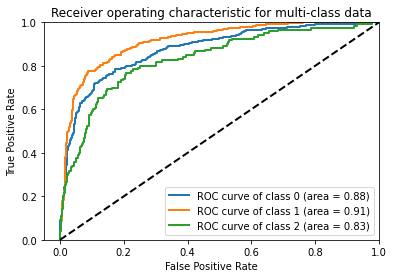

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes = 3
one_hot = np.zeros((y_train.shape[0],n_classes))
for index,label in enumerate(y_train):
    one_hot[index][label] = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot[:, i], train_probability[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],  lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# VAL ROC

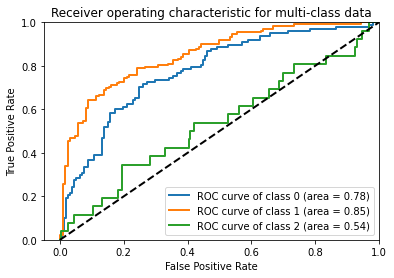

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes = 3
one_hot = np.zeros((y_val.shape[0],n_classes))
for index,label in enumerate(y_val):
    one_hot[index][label] = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot[:, i], val_probability[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],  lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Test ROC

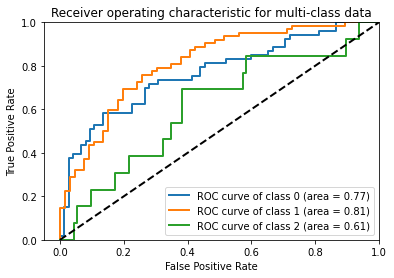

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes = 3
one_hot = np.zeros((y_test.shape[0],n_classes))
for index,label in enumerate(y_test):
    one_hot[index][label] = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot[:, i], test_probability[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],  lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()